In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
# inputフォルダに格納されているファイルの一覧を出力
for dirname, _, filenames in os.walk('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

# データを読み込み
item_categories = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/item_categories.csv')
items = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/items.csv')
sales_train = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sales_train.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sample_submission.csv')
shops = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/shops.csv')
test = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/test.csv')


/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/item_categories.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/items.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sales_train.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sample_submission.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/shops.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/test.csv


In [140]:
sales_train_groupby = sales_train.groupby(['shop_id', 'item_id']).count()
sales_train_groupby = sales_train_groupby.sort_values('date', ascending=False)

sales_train_groupby.head()

,,date,date_block_num,item_price,item_cnt_day
shop_id,item_id,,,,
28,20949,867,867,867,867
53,20949,863,863,863,863
31,20949,863,863,863,863
22,20949,848,848,848,848
42,20949,834,834,834,834


In [141]:
df = sales_train[sales_train.item_id == 20949]
df = df[df.shop_id == 28]

df['date'] = pd.to_datetime(df['date'])
df = df.drop('date_block_num', axis=1)



In [142]:
df.head()

,date,shop_id,item_id,item_price,item_cnt_day
359513,2013-04-29,28,20949,5.0,2.0
359534,2013-04-30,28,20949,5.0,5.0
449927,2013-05-31,28,20949,5.0,18.0
449973,2013-05-30,28,20949,5.0,9.0
449974,2013-05-28,28,20949,5.0,15.0


In [143]:
df.describe()

,shop_id,item_id,item_price,item_cnt_day
count,867.0,867.0,867.000000,867.000000
mean,28.0,20949.0,4.999320,15.522491
std,0.0,0.0,0.018161,11.131189
min,28.0,20949.0,4.466667,1.000000
25%,28.0,20949.0,5.000000,8.000000
50%,28.0,20949.0,5.000000,12.000000
75%,28.0,20949.0,5.000000,20.000000
max,28.0,20949.0,5.000000,71.000000


In [144]:
from datetime import date, timedelta
d1 = date(2013,1,1)
d2 = date(2015,10,31)
for i in range((d2 - d1).days + 1):
    date = d1 + timedelta(i)
    if len(df[df.date == date]) == 0:
        df = df.append({'date': date, 'shop_id': 28, 'item_id': 20949, 'item_price': 5.0, 'item_cnt_day': 0.0}, ignore_index=True)

df = df.sort_values('date')
df = df.reset_index(drop=True)

L = len(df)
Y = df.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

X1 = Y[0:L-5, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-4, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-3, :]  # 予測対象日の前日データ
X4 = Y[3:L-2, :]  # 予測対象日の前日データ
X5 = Y[4:L-1, :]  # 予測対象日の前日データ
Y = Y[5:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3, X4, X5], axis=1)  # numpy配列を結合する。

df.head(20)

,date,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,28,20949,5.000000,0.0
1,2013-01-02,28,20949,5.000000,0.0
2,2013-01-03,28,20949,5.000000,0.0
3,2013-01-04,28,20949,5.000000,0.0
4,2013-01-05 00:00:00,28,20949,4.974359,39.0
5,2013-01-06 00:00:00,28,20949,5.000000,41.0
6,2013-01-07 00:00:00,28,20949,5.000000,19.0
7,2013-01-08 00:00:00,28,20949,5.000000,16.0
8,2013-01-09 00:00:00,28,20949,5.000000,29.0
9,2013-01-10 00:00:00,28,20949,5.000000,4.0


In [145]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

print(X)

[[[0.         0.         0.         0.         0.54929577]]

 [[0.         0.         0.         0.54929577 0.57746479]]

 [[0.         0.         0.54929577 0.57746479 0.26760563]]

 ...

 [[0.11267606 0.1971831  0.05633803 0.23943662 0.21126761]]

 [[0.1971831  0.05633803 0.23943662 0.21126761 0.05633803]]

 [[0.05633803 0.23943662 0.21126761 0.05633803 0.18309859]]]


In [146]:
# train, testデータを定義
X_train = X[:700, :, :]
X_test = X[700:, :, :]
Y_train = Y[:700, :]
Y_test = Y[700:, :]

print(len(X_train))
print(len(X_test))

700
345


In [147]:
model = Sequential()
model.add(LSTM(10, 
               activation = 'tanh', 
               input_shape = (1,5), 
               recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

model.compile(loss= 'mean_squared_error', 
              optimizer = 'rmsprop', 
              metrics=[metrics.mae])
model.fit(X_train, Y_train, epochs=100, verbose=0)
Predict = model.predict(X_test)


In [148]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[5:705,0])

print(df.iloc[5:705,0])

Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[705:,0])

Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)
Predict.index=pd.to_datetime(df.iloc[705:,0])


5      2013-01-06 00:00:00
6      2013-01-07 00:00:00
7      2013-01-08 00:00:00
8      2013-01-09 00:00:00
9      2013-01-10 00:00:00
              ...         
700    2014-12-02 00:00:00
701    2014-12-03 00:00:00
702    2014-12-04 00:00:00
703    2014-12-05 00:00:00
704    2014-12-06 00:00:00
Name: date, Length: 700, dtype: object


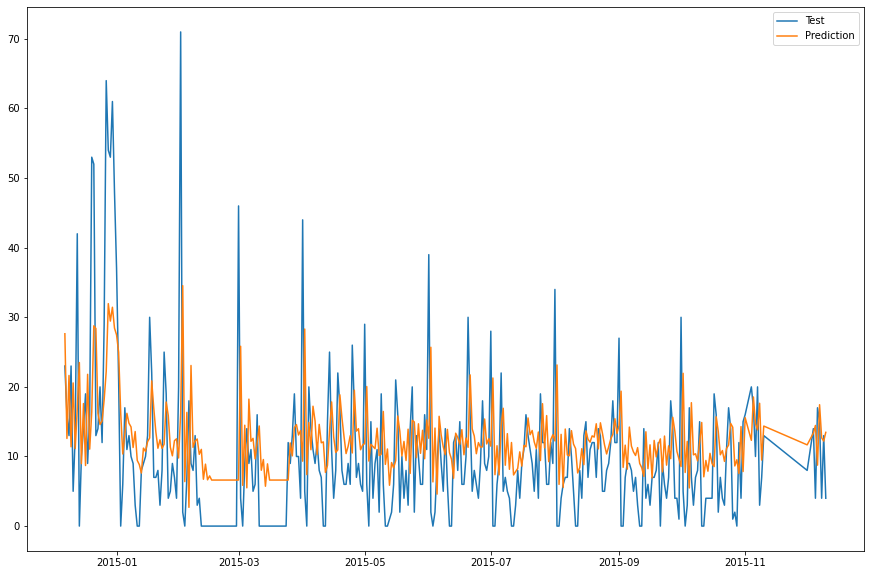

In [149]:
plt.figure(figsize=(15,10), facecolor='white')
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()